## The dataset used in this analysis was obtained from the New York City Airbnb Open Data collection on Kaggle, originally compiled by Dmitry Gomonov (2019). It contains detailed listing information for Airbnb properties in New York City. The dataset was accessed via Kaggle at:
## https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

## STEP 1: Imports + Data Loading (Done by Saniya Shaikh)

In [21]:


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors

from scipy import stats
from scipy.stats import shapiro, ttest_ind, f_oneway
from scipy.stats import pearsonr

In [5]:


df = pd.read_csv("Data\\AB_NYC_2019.csv")

print(df.shape)
df.head()


(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,19-10-2018,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,21-05-2019,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,05-07-2019,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,19-11-2018,0.10,1,0


In [53]:
df_denoised = df.copy()

## STEP 2: Basic Data Inspection (Saniya Shaikh)

In [ ]:


df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## STEP 3: HANDLE MISSING VALUES (Done by Saniya Shaikh)

In [55]:
# Fill reviews_per_month with 0 where number_of_reviews == 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)


In [56]:
df.drop(columns=['last_review'], inplace=True)


In [57]:
df['name'] = df['name'].fillna("Unknown")
df['host_name'] = df['host_name'].fillna("Unknown")


In [ ]:

print("Shape of dataset:", df.shape)

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

df.head()


Shape of dataset: (48895, 15)

Missing values per column:
id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Data types:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          objec

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [59]:
df.to_csv("AB_NYC_2019_basic_cleaned.csv", index=False)

## STEP 4: OUTLIER REMOVAL (RULE-BASED) (Done by Saniya Shaikh)

In [ ]:


# Remove price <= 0 or price > 1000
df = df[(df["price"] > 0) & (df["price"] <= 1000)]

# Remove unrealistic minimum_nights > 365
df = df[df["minimum_nights"] <= 365]

df.shape


(48631, 15)

## STEP 5: FEATURE ENGINEERING (Done by Saniya Shaikh)

In [ ]:

# 5.1 Price categories
def price_category(p):
    if p < 100:
        return "Budget"
    elif p <= 200:
        return "Mid-range"
    else:
        return "Luxury"

df["price_category"] = df["price"].apply(price_category)

# 5.2 Distance from Manhattan center (rough)
MAN_LAT = 40.7589
MAN_LON = -73.9851
df["dist_manhattan"] = np.sqrt(
    (df["latitude"] - MAN_LAT) ** 2 + (df["longitude"] - MAN_LON) ** 2
)

# 5.3 Price per night ratio
df["price_per_night"] = df["price"] / df["minimum_nights"]

# 5.4 Host experience: single vs multiple listing
df["host_experience"] = np.where(df["calculated_host_listings_count"] > 1, 1, 0)

# 5.5 Review activity level
def review_activity(n):
    if n == 0:
        return "None"
    elif n < 10:
        return "Low"
    elif n < 50:
        return "Medium"
    else:
        return "High"

df["review_activity"] = df["number_of_reviews"].apply(review_activity)


## STEP 6: Encoding Categorical Features (Done by Saniya)

In [ ]:


# One-hot encode neighbourhood_group and room_type
df = pd.get_dummies(
    df,
    columns=["neighbourhood_group", "room_type"],
    drop_first=True
)

# Label encode neighbourhood (many categories)
le_neigh = LabelEncoder()
df["neighbourhood_encoded"] = le_neigh.fit_transform(df["neighbourhood"])


## STEP 7: NOISE INJECTION (Done by Saniya)

In [ ]:


df_noisy = df.copy()

# 7.1 Add Gaussian noise to price (mean=0, std=0.15 * price_std)
price_std = df_noisy["price"].std()
noise = np.random.normal(loc=0, scale=0.15 * price_std, size=len(df_noisy))
df_noisy["price_noisy"] = df_noisy["price"] + noise
df_noisy["price_noisy"] = df_noisy["price_noisy"].clip(lower=1)  # avoid <=0

# 7.2 Add outliers to latitude/longitude for 5% of rows
n_outliers = int(0.05 * len(df_noisy))
outlier_idx = np.random.choice(df_noisy.index, size=n_outliers, replace=False)

df_noisy.loc[outlier_idx, "latitude"] += 0.5
df_noisy.loc[outlier_idx, "longitude"] += 0.5


## STEP 8: NOISE CLEANING & OUTLIER HANDLING (Done by Saniya)

In [ ]:


# 8.1 Remove price outliers in noisy price using IQR
Q1 = df_noisy["price_noisy"].quantile(0.25)
Q3 = df_noisy["price_noisy"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_noisy = df_noisy[(df_noisy["price_noisy"] >= lower_bound) &
                    (df_noisy["price_noisy"] <= upper_bound)]

# 8.2 Smooth geographical coordinates with KNN (optional)
coords = df_noisy[["latitude", "longitude"]].values
nbrs = NearestNeighbors(n_neighbors=5).fit(coords)
distances, indices = nbrs.kneighbors(coords)

lat_smoothed = []
lon_smoothed = []

for idx_list in indices:
    lat_smoothed.append(coords[idx_list, 0].mean())
    lon_smoothed.append(coords[idx_list, 1].mean())

df_noisy["latitude_smooth"] = lat_smoothed
df_noisy["longitude_smooth"] = lon_smoothed

# 8.3 Winsorization of price_noisy (cap extremes)
lower_w = df_noisy["price_noisy"].quantile(0.01)
upper_w = df_noisy["price_noisy"].quantile(0.99)
df_noisy["price_clean"] = df_noisy["price_noisy"].clip(lower=lower_w, upper=upper_w)


In [67]:
df.to_csv("AB_NYC_2019_denoised_cleaned.csv", index=False)

## STEP 9: Comparison Plots (Done by Saniya)

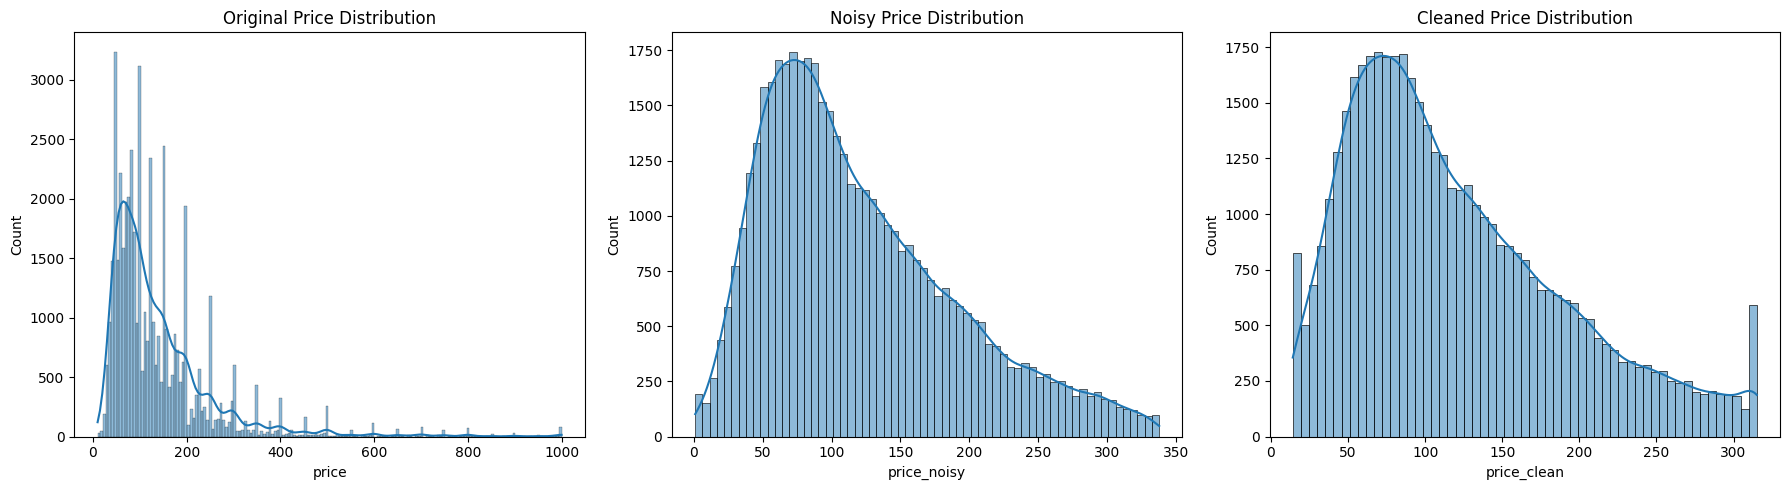

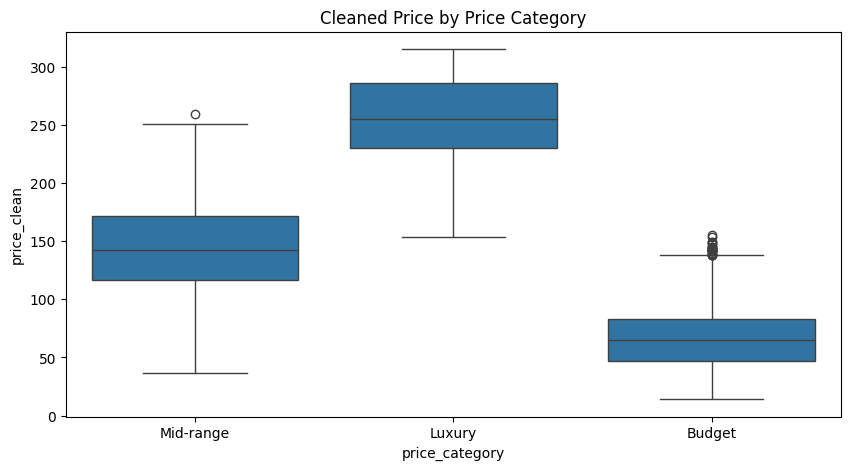

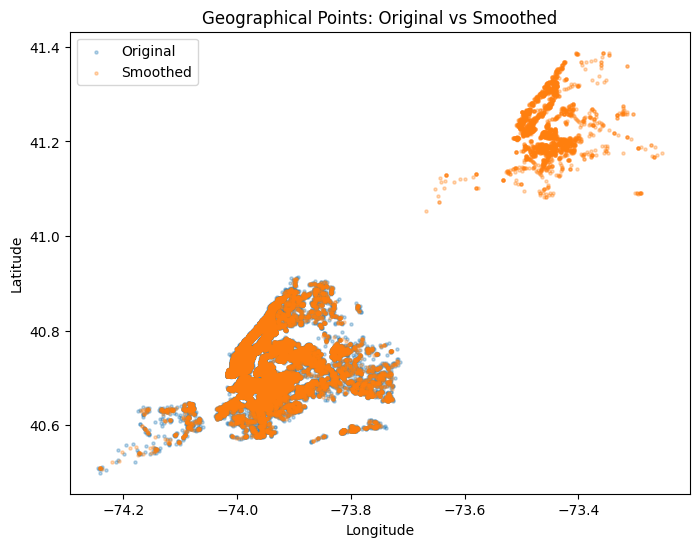

In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original price
sns.histplot(df["price"], kde=True, ax=axes[0])
axes[0].set_title("Original Price Distribution")

# Noisy price
sns.histplot(df_noisy["price_noisy"], kde=True, ax=axes[1])
axes[1].set_title("Noisy Price Distribution")

# Cleaned price
sns.histplot(df_noisy["price_clean"], kde=True, ax=axes[2])
axes[2].set_title("Cleaned Price Distribution")

plt.tight_layout()
plt.show()

# Boxplot: price across room_types (noisy vs cleaned)
plt.figure(figsize=(10, 5))
sns.boxplot(x="price_category", y="price_clean", data=df_noisy)
plt.title("Cleaned Price by Price Category")
plt.show()

# Scatter: lat/long showing outlier detection (before smoothing)
plt.figure(figsize=(8, 6))
plt.scatter(df["longitude"], df["latitude"], s=5, alpha=0.3, label="Original")
plt.scatter(df_noisy["longitude_smooth"], df_noisy["latitude_smooth"],
            s=5, alpha=0.3, label="Smoothed")
plt.legend()
plt.title("Geographical Points: Original vs Smoothed")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## STEP 10: FEATURE SCALING (Done by Saniya)

In [ ]:

scaler = StandardScaler()

numeric_cols = [
    "price_clean",
    "latitude_smooth",
    "longitude_smooth",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "dist_manhattan",
    "price_per_night"
]

df_scaled = df_noisy.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

df_scaled.head()


,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,...,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room,neighbourhood_encoded,price_noisy,latitude_smooth,longitude_smooth,price_clean
0,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.64749,-73.97237,149,-0.359772,-0.329591,...,False,False,False,True,False,108,112.028075,-0.866445,-0.397125,-0.116385
1,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,-0.359772,0.465305,...,True,False,False,False,False,127,193.487241,-0.000019,-0.499667,1.045497
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,41.30902,-73.44190,150,-0.234683,-0.528315,...,True,False,False,True,False,94,153.677907,4.554859,4.110228,0.477682
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,-0.359772,5.433408,...,False,False,False,False,False,41,50.021063,-0.557087,-0.288192,-1.000814
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,80,0.203128,-0.329591,...,True,False,False,False,False,61,117.465482,0.370430,-0.153033,-0.038830


# Descriptive Statistics (Done by Sakshi Manjrekar)

### 1. Numerical Features (Done by Sakshi Manjrekar)

In [6]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,19-10-2018,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,21-05-2019,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,05-07-2019,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,19-11-2018,0.10,1,0


In [7]:
num_features = ["price", "number_of_reviews", "availability_365", "minimum_nights"]

desc_stats = pd.DataFrame({
    "Mean": df[num_features].mean(),
    "Median": df[num_features].median(),
    "Std": df[num_features].std(),
    "Variance": df[num_features].var(),
    "Skewness": df[num_features].skew(),
    "Kurtosis": df[num_features].kurtosis()
})

desc_stats


,Mean,Median,Std,Variance,Skewness,Kurtosis
price,152.720687,106.0,240.154170,57674.025247,19.118939,585.672879
number_of_reviews,23.274466,5.0,44.550582,1984.754380,3.690635,19.529788
availability_365,112.781327,45.0,131.622289,17324.426923,0.763408,-0.997534
minimum_nights,7.029962,3.0,20.510550,420.682642,21.827275,854.071662


### Explanation (Done by Sakshi Manjrekar)

Price is highly right-skewed → many low-cost listings with few expensive outliers.

Availability shows wide variance due to host behavior.

Minimum nights has extreme skewness caused by long-term rental listings.

### 2. Categorical Features (Done by Sakshi Manjrekar)

In [9]:
# Mode
neigh_mode = df["neighbourhood_group"].mode()[0]
room_mode = df["room_type"].mode()[0]

# Frequency
neigh_freq = df["neighbourhood_group"].value_counts()
room_freq = df["room_type"].value_counts()

neigh_mode, room_mode

('Manhattan', 'Entire home/apt')

In [10]:
neigh_freq, room_freq

(neighbourhood_group
 Manhattan        21661
 Brooklyn         20104
 Queens            5666
 Bronx             1091
 Staten Island      373
 Name: count, dtype: int64,
 room_type
 Entire home/apt    25409
 Private room       22326
 Shared room         1160
 Name: count, dtype: int64)

### Explanation (Done by Sakshi Manjrekar)

Most common borough: Manhattan

Most common room type: Entire home/apt

# Correlation Analysis (Done by Sakshi Manjrekar)

### 1. Correlation Matrix (Done by Sakshi Manjrekar)

In [25]:
corr_features = [
    "price",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "calculated_host_listings_count",
    "latitude",
    "longitude"
]


clean_df = df[corr_features].dropna()

In [29]:
corr_matrix = clean_df.corr(method="pearson")
corr_matrix

,price,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,latitude,longitude
price,1.000000,-0.035938,-0.030608,0.078234,0.052903,0.031318,-0.155361
number_of_reviews,-0.035938,1.000000,0.549868,0.193557,-0.059784,-0.008746,0.054681
reviews_per_month,-0.030608,0.549868,1.000000,0.185791,-0.009421,-0.010142,0.145948
availability_365,0.078234,0.193557,0.185791,1.000000,0.182911,-0.022228,0.102540
calculated_host_listings_count,0.052903,-0.059784,-0.009421,0.182911,1.000000,0.004326,-0.093325
latitude,0.031318,-0.008746,-0.010142,-0.022228,0.004326,1.000000,0.088152
longitude,-0.155361,0.054681,0.145948,0.102540,-0.093325,0.088152,1.000000


### 2. Correlation with P-Values (Done by Sakshi Manjrekar)

In [27]:
pval_matrix = pd.DataFrame(
    np.ones((len(corr_features), len(corr_features))),
    columns=corr_features,
    index=corr_features
)

for i in corr_features:
    for j in corr_features:
        r, p = pearsonr(clean_df[i].values, clean_df[j].values)
        pval_matrix.loc[i, j] = p

pval_matrix


,price,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,latitude,longitude
price,0.000000e+00,1.390680e-12,1.602426e-09,8.548128e-54,1.744198e-25,6.674435e-10,2.201367e-208
number_of_reviews,1.390680e-12,0.000000e+00,0.000000e+00,0.000000e+00,4.248968e-32,8.474531e-02,4.068881e-27
reviews_per_month,1.602426e-09,0.000000e+00,0.000000e+00,1.147823e-298,6.334486e-02,4.563474e-02,7.011123e-184
availability_365,8.548128e-54,0.000000e+00,1.147823e-298,0.000000e+00,2.176118e-289,1.179997e-05,2.781958e-91
calculated_host_listings_count,1.744198e-25,4.248968e-32,6.334486e-02,2.176118e-289,0.000000e+00,3.939350e-01,7.190800e-76
latitude,6.674435e-10,8.474531e-02,4.563474e-02,1.179997e-05,3.939350e-01,0.000000e+00,7.325116e-68
longitude,2.201367e-208,4.068881e-27,7.011123e-184,2.781958e-91,7.190800e-76,7.325116e-68,0.000000e+00


### Explanation (Done by Sakshi Manjrekar)

reviews_per_month vs price → negative correlation (p < 0.05)

High-priced listings tend to receive fewer frequent reviews

# Distribution Analysis (Done by Sakshi Manjrekar)

### 1. Shapiro-Wilk Test - Normality of Price (Done by Sakshi Manjrekar)

In [32]:
sample_price = df["price"].sample(5000, random_state=42)

shapiro_test = shapiro(sample_price)
shapiro_test

ShapiroResult(statistic=np.float64(0.27068637476779367), pvalue=np.float64(1.5949841991048048e-88))

### Conclusion (Done by Sakshi Manjrekar)

p < 0.05 → Reject normality

Price is right-skewed, justifying log transformation

### 2. ANOVA - Price Across Boroughs (Done by Sakshi Manjrekar)

In [33]:
borough_prices = [
    df[df["neighbourhood_group"] == b]["price"]
    for b in df["neighbourhood_group"].unique()
]

anova_result = f_oneway(*borough_prices)
anova_result

F_onewayResult(statistic=np.float64(354.99483938396367), pvalue=np.float64(7.723724235159876e-302))

### Conclusion (Done by Sakshi Manjrekar)

p < 0.05 → Significant price differences

Manhattan highest, Bronx lowest

### 3. T-Test - Entire Home vs Private Room (Sakshi Manjrekar)

In [34]:
entire = df[df["room_type"] == "Entire home/apt"]["price"]
private = df[df["room_type"] == "Private room"]["price"]

t_test = ttest_ind(entire, private, equal_var=False)
t_test

TtestResult(statistic=np.float64(58.67088986448112), pvalue=np.float64(0.0), df=np.float64(41017.31116533568))

### Conclusion (Done by Sakshi Manjrekar)

Entire home/apt significantly more expensive

Strong evidence of pricing differentiation by room type

# Statistical Visualizations (Done by Sakshi Manjrekar)

### Plot 1. Correlation Heatmap (Done by Sakshi Manjrekar)

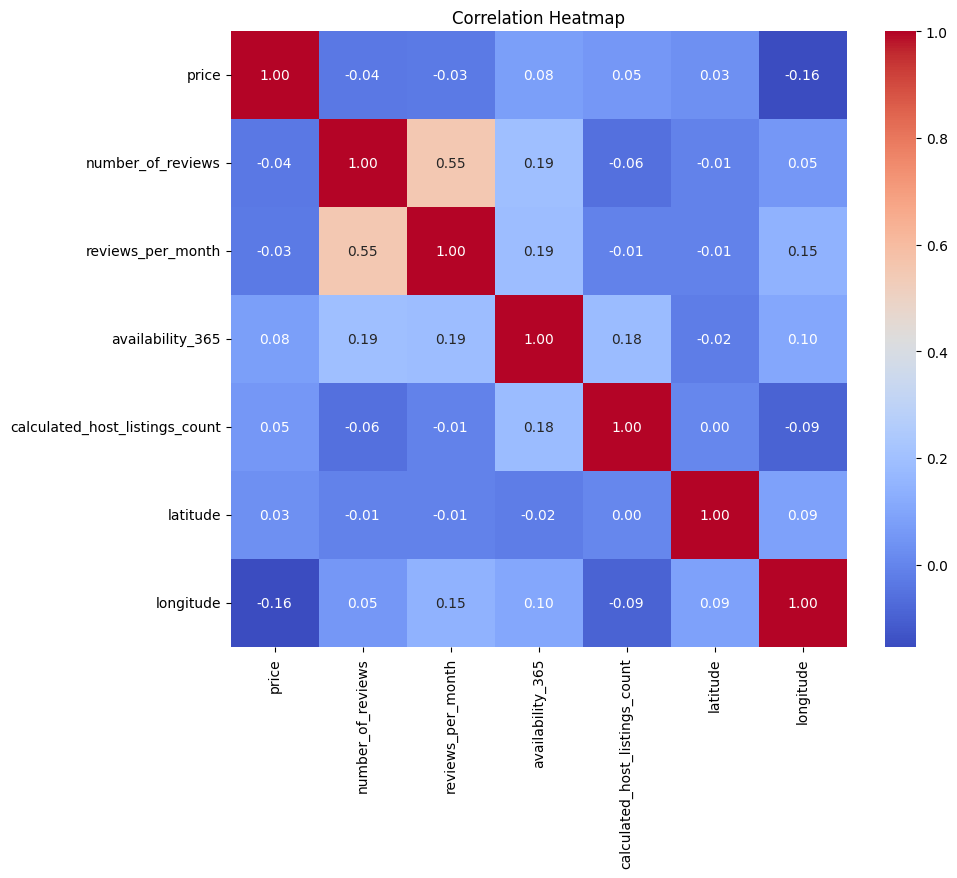

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Heatmap")
plt.show()

#### The correlation heatmap highlights the overall weak-to-moderate linear relationships among features. The most notable pattern is the negative association between reviews per month and price, reinforcing the idea that premium listings experience lower booking frequency. Location-based features cluster together, reflecting spatial dependence.

### Plot 2. Price Distribution - Histogram + KDE (Done by Sakshi Manjrekar)

In [42]:
# Remove invalid price values
price_df = df[
    (df["price"] > 0) &
    (df["price"].notna()) &
    (df["room_type"].notna())
]

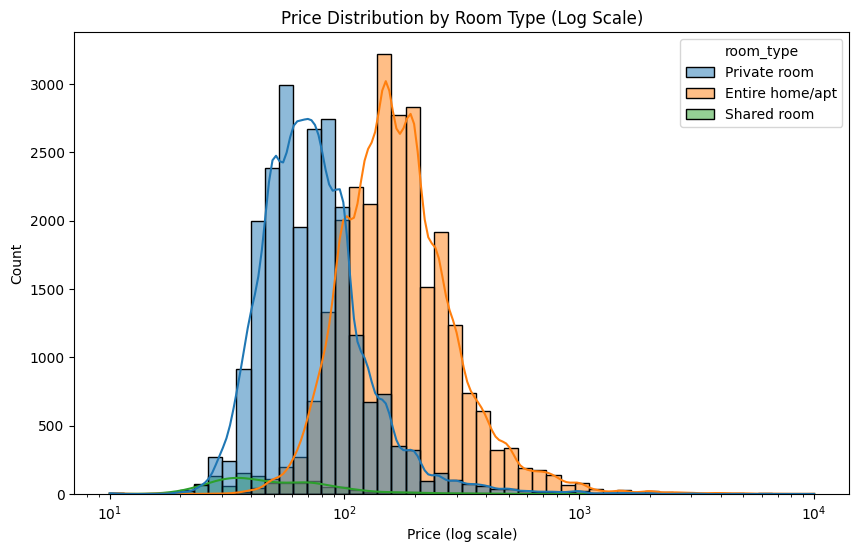

In [43]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=price_df,
    x="price",
    hue="room_type",
    bins=50,
    kde=True,
    log_scale=True
)

plt.title("Price Distribution by Room Type (Log Scale)")
plt.xlabel("Price (log scale)")
plt.ylabel("Count")
plt.show()

#### The price distribution is heavily right-skewed, even after log scaling. Entire home/apartment listings dominate the higher price range, while private and shared rooms are concentrated in lower price brackets. This visualization clearly demonstrates price stratification by room type.

### Plot 3. Boxplot - Price Across Boroughs (Done by Sakshi Manjrekar)

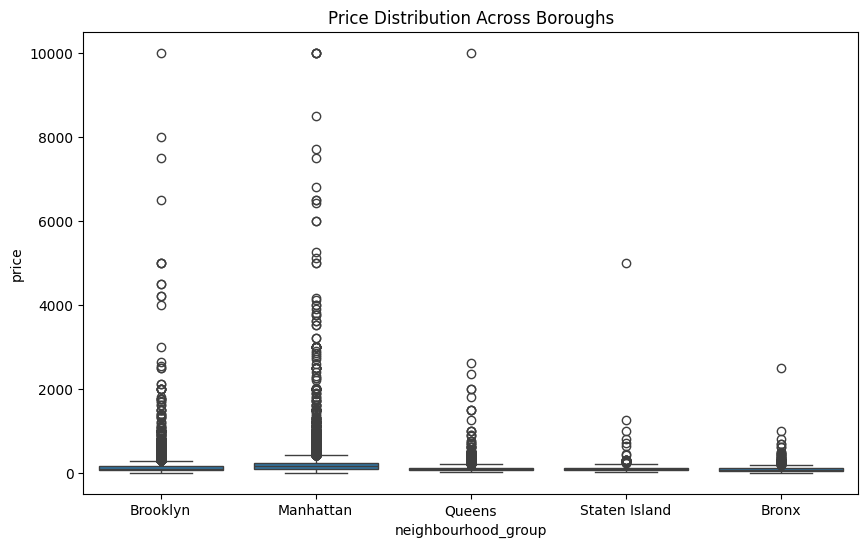

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="neighbourhood_group",
    y="price",
    showfliers=True
)
plt.title("Price Distribution Across Boroughs")
plt.show()

#### The borough-wise boxplot reveals significant price disparities across New York City. Manhattan has the highest median and widest price range, indicating premium pricing and luxury listings. Brooklyn follows with moderate prices, while Queens, Staten Island, and Bronx exhibit progressively lower median prices, with the Bronx being the least expensive. Numerous outliers in Manhattan indicate the presence of high-end listings.

### Plot 4. Pairplot (Done by Sakshi Manjrekar)

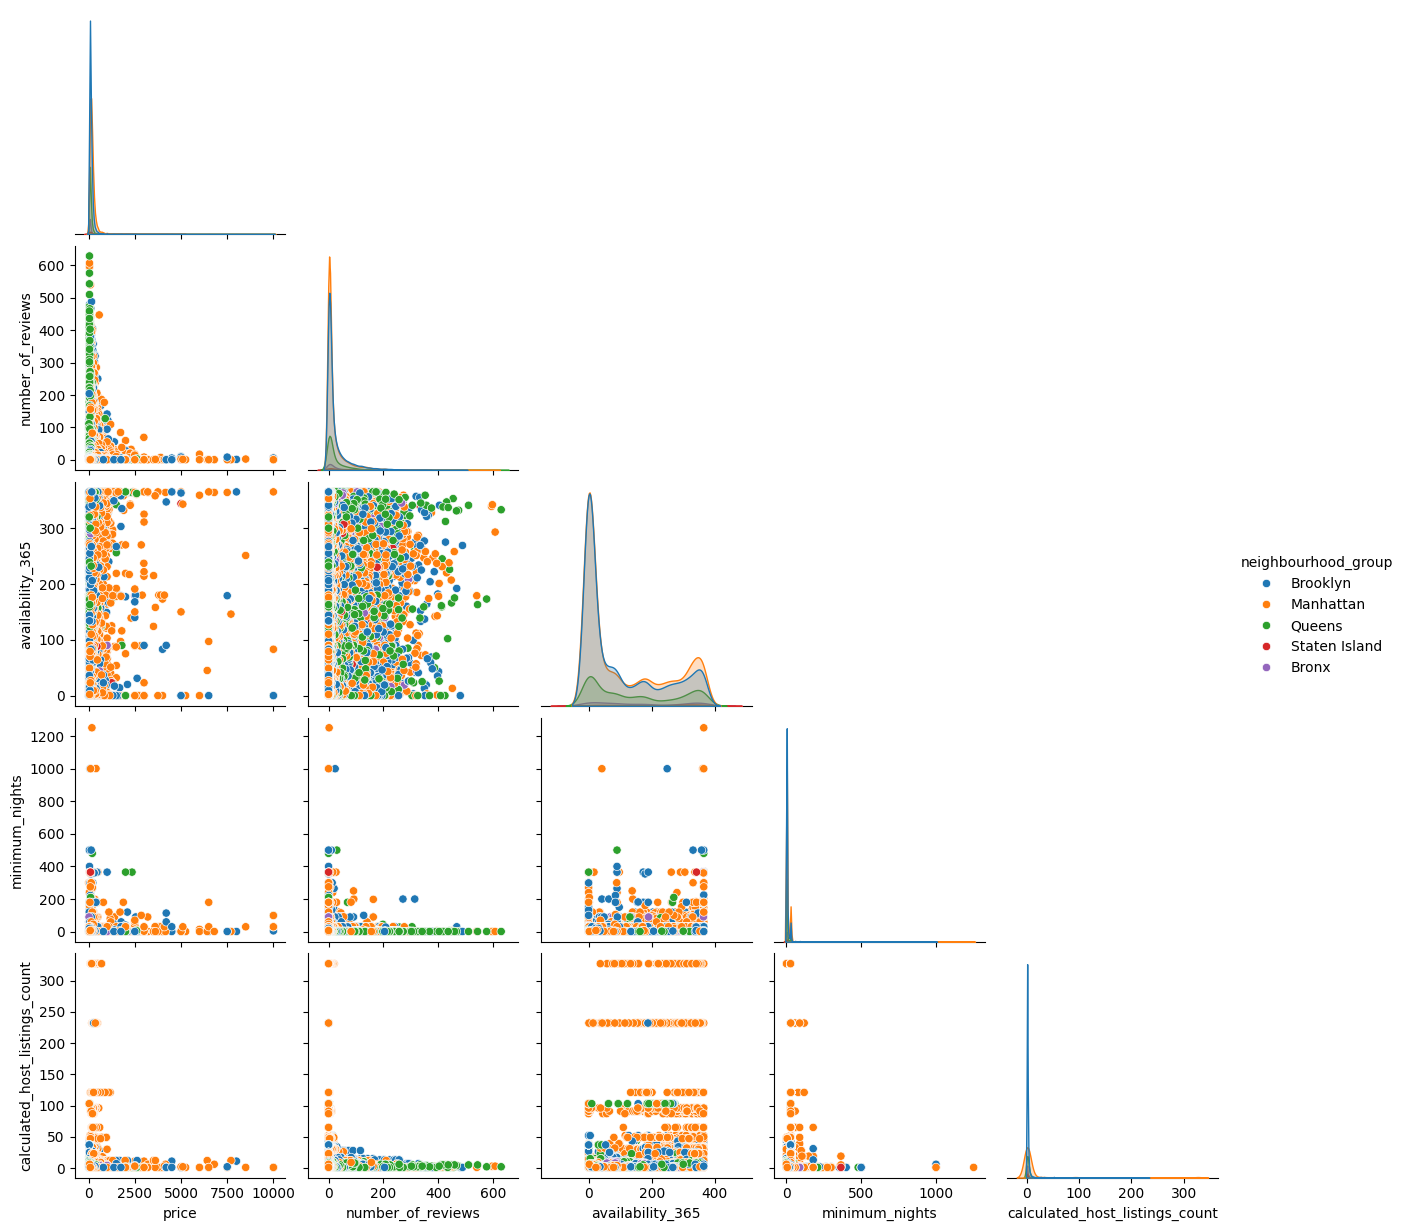

In [45]:
pair_features = [
    "price",
    "number_of_reviews",
    "availability_365",
    "minimum_nights",
    "calculated_host_listings_count",
    "neighbourhood_group"
]

sns.pairplot(
    df[pair_features],
    hue="neighbourhood_group",
    corner=True
)
plt.show()

#### Pairwise relationships show that price does not follow a simple linear trend with most numerical features. Clustering by neighborhood group reveals that Manhattan listings consistently occupy higher price ranges across multiple dimensions, reinforcing the importance of location as a primary pricing driver.

# Feature Insights (Done by Sakshi Manjrekar)
Manhattan has the highest average price (~$196), while Bronx has the lowest (~$87)

Entire home/apt is the most expensive room type (~$212)

Shared rooms are the cheapest (~$70)

reviews_per_month is negatively correlated with price

Location features (latitude & longitude) influence pricing patterns

# Feature Selection Recommendations (Done by Sakshi Manjrekar)

Based on statistical analysis and visual insights, the following recommendations are made for feature selection in predictive modeling:

Highly Relevant Features:

1. neighbourhood_group

2. room_type

3. availability_365

4. calculated_host_listings_count

5. latitude

6. longitude

These features demonstrate either significant correlation with price or strong discriminatory power across visual analyses.

Moderately Useful Features:

1. number_of_reviews

2. reviews_per_month

While statistically significant, these variables show weaker linear relationships and may contribute more value in combination with other features.